In [1]:
import requests
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from pandas import json_normalize
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from collections import Counter
from progressbar import progressbar
import math

pd.options.display.max_rows = 9999
pd.options.display.max_columns = 9999

# Insert your own client ID here
client_id = '68e4dc04-3f18-4f9f-8a0a-9c793d40bd79'

In [48]:
l1 = [1,2,3,4,np.nan,np.nan,np.nan,5,6,np.nan,7,8]
l2 = [np.nan,np.nan,np.nan,np.nan,10,11,12,np.nan,np.nan,13,np.nan,np.nan]
# print(l1)
# print(l2)
list1 = [i for i in range(0,len(l1)) if math.isnan(l1[i]) and not math.isnan(l1[i-1])]
list2 = [i for i in range(0,len(l2)) if math.isnan(l2[i]) and not math.isnan(l2[i-1])]
l1 = [l2[i]  if i in list1 else l1[i] for i in range(0,len(l1))]
l2 = [l1[i]  if i in list2 else l2[i] for i in range(0,len(l2))]
print(l1)
print(l2)

[1, 2, 3, 4, 10, nan, nan, 5, 6, 13, 7, 8]
[nan, nan, nan, nan, 10, 11, 12, 5, nan, 13, 7, nan]


In [101]:
timerange=(str((datetime.today() - timedelta(days=29)).date())+'/'+str((datetime.today() - timedelta(days=27)).date()))

def load_features():
    air_temperature = graphelement(source='SN18700',elements= 'air_temperature',referencetime= timerange,rollingmean=1)
    precipitation = graphelement(source='SN18700',elements= 'sum(precipitation_amount P1D)',referencetime= timerange,rollingmean=1)
    return air_temperature, precipitation

df_temperature, df_precipitation = load_features()
df_temperature_positive = df_temperature.copy()
df_temperature_positive.loc[df_temperature_positive.value <= 0, 'value'] = np.nan
df_temperature_negative = df_temperature.copy()
df_temperature_negative.loc[df_temperature_negative.value > 0, 'value'] = np.nan

list1 = [i for i in range(1,len(df_temperature_positive)) if math.isnan(df_temperature_positive.value[i]) and not math.isnan(df_temperature_positive.value[i-1])]
list2 = [i for i in range(1,len(df_temperature_negative)) if math.isnan(df_temperature_negative.value[i]) and not math.isnan(df_temperature_negative.value[i-1])]
# df_temperature_positive['value'] = [df_temperature_negative.value[i]  if i in list1 else df_temperature_positive.value[i] for i in range(0,len(df_temperature_positive))]
# df_temperature_negative['value'] = [df_temperature_positive.value[i]  if i in list2 else df_temperature_negative.value[i] for i in range(0,len(df_temperature_negative))]

Data retrieved from frost.met.no!
Data retrieved from frost.met.no!


In [95]:
list2

[89, 91, 161, 165, 171]

In [2]:
def findstation(ids=None,name=None,country=None,municipality=None,validtime=None,polygon=None,nearpoint=None):
    dflocal=pd.DataFrame([locals()])
    selec=''
    for col in dflocal.columns:
        if dflocal[col][0] != None:
            if col == 'nearpoint':
                selec+='&geometry=nearest(POINT('+str(dflocal[col][0])+'))'
            elif col == 'polygon':
                selec+='&geometry=POLYGON(('+str(dflocal[col][0])+'))'
            else:
                selec+='&'+str(col)+'='+str(dflocal[col][0])
    endpoint='https://frost.met.no/sources/v0.jsonld?types=SensorSystem'+selec
    print(endpoint,'\n')
    r = requests.get(endpoint, auth=(client_id,''))
    # Extract JSON data
    json = r.json()

    # Check if the request worked, print out any errors
    if r.status_code == 200:
        data = json['data']
        print('Data retrieved from frost.met.no!\n')
    else:
        print('Error! Returned status code %s' % r.status_code)
        print('Message: %s' % json['error']['message'])
        print('Reason: %s' % json['error']['reason'])
    return json_normalize(data)

In [3]:
def sourceinfo(source,filt=''):
    endpoint = 'https://frost.met.no/observations/availableTimeSeries/v0.jsonld?sources='+ source
    r = requests.get(endpoint, auth=(client_id,''))
    # Extract JSON data
    json = r.json()
    # Check if the request worked, print out any errors
    row=[]
    row2=[]
    row3=[]
    elements=pd.DataFrame()
    if r.status_code == 200:
        data = json['data']
        print('Data retrieved from frost.met.no!\n')
        for i in range(len(data)):
            # if filt in data[i]['elementId']:
            row.append(data[i]['elementId'])
            row2.append(data[i]['validFrom'])
            try:
                row3.append(data[i]['validTo'])
            except:
                row3.append(np.nan)
        elements['elementId']=row
        elements['validFrom']=row2
        elements['validTo']=row3
    else:
        print('Error! Returned status code %s' % r.status_code)
        print('Message: %s' % json['error']['message'])
        print('Reason: %s' % json['error']['reason'])
    return elements

In [4]:
def graphelement(source,elements,referencetime,rollingmean=1):

    # Define endpoint and parameters
    endpoint = 'https://frost.met.no/observations/v0.jsonld'
    parameters = {
        'sources': source,
        'elements': elements,
        'referencetime': referencetime,
    }
    # Issue an HTTP GET request
    r = requests.get(endpoint, parameters, auth=(client_id,''))
    # Extract JSON data
    json = r.json()

    # Check if the request worked, print out any errors
    if r.status_code == 200:
        data = json['data']
        print('Data retrieved from frost.met.no!')
    else:
        print('Error! Returned status code %s' % r.status_code)
        print('Message: %s' % json['error']['message'])
        print('Reason: %s' % json['error']['reason'])

    df = pd.DataFrame()
    for i in range(len(data)):
        df.loc[i,'sourceId'] = data[i]['sourceId']
        df.loc[i,'referenceTime'] = data[i]['referenceTime']
        df.loc[i,'value'] = data[i]['observations'][0]['value']

    df = df.reset_index()[['referenceTime','value']]
    df['referenceTime'] = [datetime.strptime(each, '%Y-%m-%dT%H:%M:%S.%fZ') for each in df['referenceTime']]
    df['value']=df['value'].rolling(rollingmean).mean()

    # plt.figure(figsize=(30,10))
    # ax = sns.lineplot(x="referenceTime", y="value", data=df)

    return df,data

In [9]:
allids = findstation(country='Norge').id.values

https://frost.met.no/sources/v0.jsonld?types=SensorSystem&country=Norge 

Data retrieved from frost.met.no!



In [45]:
df = findstation(country='Norge')

https://frost.met.no/sources/v0.jsonld?types=SensorSystem&country=Norge 

Data retrieved from frost.met.no!



In [133]:
findstation(municipality='aurskog-høland')

https://frost.met.no/sources/v0.jsonld?types=SensorSystem&municipality=aurskog-høland 

Data retrieved from frost.met.no!



,@type,id,name,country,countryCode,masl,validFrom,county,countyId,municipality,municipalityId,stationHolders,geometry.@type,geometry.coordinates,geometry.nearest,shortName,externalIds,wigosId,wmoId
0,SensorSystem,SN2000,RØMSKOG,Norge,NO,140,1500-01-01T00:00:00.000Z,VIKEN,30,AURSKOG-HØLAND,3026,[],Point,"[11.82, 59.73]",False,NaN,NaN,NaN,NaN
1,SensorSystem,SN2830,FV115 HEMNES,Norge,NO,141,2020-09-16T00:00:00.000Z,VIKEN,30,AURSKOG-HØLAND,3026,[STATENS VEGVESEN],Point,"[11.4178, 59.7267]",False,FV115 Hemnes,"[1838, 3000088]",NaN,NaN
2,SensorSystem,SN2480,FV21 TANGEN,Norge,NO,171,2015-11-04T00:00:00.000Z,VIKEN,30,AURSKOG-HØLAND,3026,[STATENS VEGVESEN],Point,"[11.7178, 59.8438]",False,FV21 Tangen,"[1561, 229020]",0-578-0-2480,NaN
3,SensorSystem,SN2650,AURSKOG II,Norge,NO,128,2007-11-28T00:00:00.000Z,VIKEN,30,AURSKOG-HØLAND,3026,[MET.NO],Point,"[11.5801, 59.9119]",False,Aurskog,"[0-20000-0-01484, 10.249.0.156]",0-20000-0-01484,1484.0
4,SensorSystem,SN2560,FV169 ÅSERUD,Norge,NO,204,2014-09-11T00:00:00.000Z,VIKEN,30,AURSKOG-HØLAND,3026,[STATENS VEGVESEN],Point,"[11.3625, 59.8388]",False,Fv169 Åserud,"[200020, 313]",0-578-0-2560,NaN


In [135]:
dftp = sourceinfo(source='SN18700',filt='')
dftp[dftp.elementId.isin(subelements)]

Data retrieved from frost.met.no!



,elementId,validFrom,validTo
13,air_temperature,1937-01-01T00:00:00.000Z,1992-12-01T00:00:00.000Z
14,air_temperature,2020-03-06T00:00:00.000Z,NaN
15,air_temperature,1992-12-01T00:00:00.000Z,NaN
16,air_temperature,2020-03-06T00:00:00.000Z,NaN
17,air_temperature,2006-12-16T00:00:00.000Z,NaN
135,wind_speed,1992-12-01T00:00:00.000Z,NaN
136,wind_speed,2016-02-24T00:00:00.000Z,NaN
137,wind_speed,1951-01-01T00:00:00.000Z,1992-12-01T00:00:00.000Z
144,sum(precipitation_amount P1D),1937-03-01T00:00:00.000Z,NaN
145,sum(precipitation_amount P1D),1937-03-01T00:00:00.000Z,NaN


In [129]:
idscomplete = []
subelements = ['air_temperature','sum(precipitation_amount P1D)','sum(precipitation_amount P1M)','sum(precipitation_amount P1Y)','wind_from_direction', 'wind_speed']
for each in progressbar(allids):
    try:
        df = sourceinfo(source=each)
        # print(df[df.elementId == 'air_temperature'].validTo.isna().sum()>0)
        # if(all([x in pd.unique(df.elementId) for x in subelements if df[df.elementId == x].validTo.isna().sum() > 0])):
        if  len([x for x in subelements if df[df.elementId == x].validTo.isna().sum() > 0]) == len(subelements):
            idscomplete.append(each)
        # [print(math.isnan(df[df.elementId =='air_temperature'].validTo.values[0])) for x in subelements]
    except:
        pass

ETA:   0:01:38Data retrieved from frost.met.no!

 89% (1423 of 1596) |#################   | Elapsed Time: 0:13:31 ETA:   0:01:31Data retrieved from frost.met.no!

 89% (1424 of 1596) |#################   | Elapsed Time: 0:13:32 ETA:   0:01:24Data retrieved from frost.met.no!

 89% (1425 of 1596) |#################   | Elapsed Time: 0:13:32 ETA:   0:01:17Data retrieved from frost.met.no!

 89% (1426 of 1596) |#################   | Elapsed Time: 0:13:32 ETA:   0:01:22Data retrieved from frost.met.no!

 89% (1427 of 1596) |#################   | Elapsed Time: 0:13:33 ETA:   0:01:30Data retrieved from frost.met.no!

 89% (1428 of 1596) |#################   | Elapsed Time: 0:13:33 ETA:   0:01:23Data retrieved from frost.met.no!

 89% (1429 of 1596) |#################   | Elapsed Time: 0:13:34 ETA:   0:01:30Data retrieved from frost.met.no!

 89% (1430 of 1596) |#################   | Elapsed Time: 0:13:35 ETA:   0:01:28Data retrieved from frost.met.no!

 89% (1431 of 1596) |################# 

In [131]:
pd.DataFrame(idscomplete).to_csv('ids_basic_nonan.csv')

In [130]:
len(idscomplete)

112

In [41]:
allelements = []
for each in allids:
    print(each)
    try:
        df = sourceinfo(source=each)
        allelements.append(pd.unique(df.elementId))
    except:
        pass
allelements = [item for each in allelements for item in each]
count_elements = Counter(allelements).most_common()

a retrieved from frost.met.no!

SN88630
Data retrieved from frost.met.no!

SN11060
Data retrieved from frost.met.no!

SN49800
Data retrieved from frost.met.no!

SN3030
Data retrieved from frost.met.no!

SN50240
Data retrieved from frost.met.no!

SN30340
Data retrieved from frost.met.no!

SN44390
Data retrieved from frost.met.no!

SN62890
Data retrieved from frost.met.no!

SN37760
Data retrieved from frost.met.no!

SN27460
Data retrieved from frost.met.no!

SN84970
Data retrieved from frost.met.no!

SN9400
Data retrieved from frost.met.no!

SN36710
Data retrieved from frost.met.no!

SN55928
Data retrieved from frost.met.no!

SN59660
Data retrieved from frost.met.no!

SN50105
Data retrieved from frost.met.no!

SN3990
Data retrieved from frost.met.no!

SN80340
Data retrieved from frost.met.no!

SN60010
Data retrieved from frost.met.no!

SN24670
Data retrieved from frost.met.no!

SN44480
Data retrieved from frost.met.no!

SN56780
Data retrieved from frost.met.no!

SN45350
Data retrieved fr

In [7]:
# pd.DataFrame(count_elements).to_csv('count_elements.csv')
# count_elements

In [63]:
dff = pd.DataFrame()
row = pd.DataFrame()
for i in range(len(data[:10])):
    dff.loc[i,'sourceId'] = data[i]['sourceId']
    dff.loc[i,'referenceTime'] = data[i]['referenceTime']
    dff.loc[i,'value'] = data[i]['observations'][0]['value']
dff

,sourceId,referenceTime,value
0,SN18700:0,2020-05-14T00:00:00.000Z,3.8
1,SN18700:0,2020-05-14T00:10:00.000Z,3.7
2,SN18700:0,2020-05-14T00:20:00.000Z,3.7
3,SN18700:0,2020-05-14T00:30:00.000Z,3.6
4,SN18700:0,2020-05-14T00:40:00.000Z,3.5
5,SN18700:0,2020-05-14T00:50:00.000Z,3.2
6,SN18700:0,2020-05-14T01:00:00.000Z,2.8
7,SN18700:0,2020-05-14T01:10:00.000Z,2.4
8,SN18700:0,2020-05-14T01:20:00.000Z,2.1
9,SN18700:0,2020-05-14T01:30:00.000Z,1.9


In [137]:
df = graphelement(source='SN18700', elements= 'sum(precipitation_amount P1Y)	',referencetime= '1991-01-20/2021-01-22',rollingmean=1)
df

Data retrieved from frost.met.no!


,referenceTime,value
0,1992-01-01,753.5
1,1993-01-01,762.0
2,1994-01-01,661.4
3,1995-01-01,699.3
4,1996-01-01,669.0
5,1997-01-01,587.3
6,1998-01-01,797.4
7,1999-01-01,944.9
8,2000-01-01,1172.6
9,2001-01-01,817.8


(array([14., 38., 61., 35., 17.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  4.,  2.,  9.,  7.,  5., 10., 20., 23., 15., 12.,  6.,  1.,
         0.,  3.,  0.,  0.,  0.,  3.]),
 array([ 20.   ,  27.125,  34.25 ,  41.375,  48.5  ,  55.625,  62.75 ,
         69.875,  77.   ,  84.125,  91.25 ,  98.375, 105.5  , 112.625,
        119.75 , 126.875, 134.   , 141.125, 148.25 , 155.375, 162.5  ,
        169.625, 176.75 , 183.875, 191.   , 198.125, 205.25 , 212.375,
        219.5  , 226.625, 233.75 , 240.875, 248.   ]),
 <BarContainer object of 32 artists>)

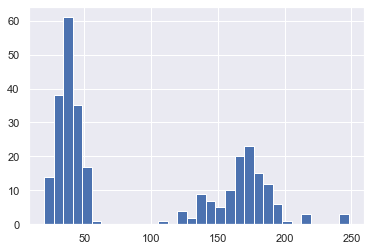

In [16]:
plt.hist(df.value,bins=32)

In [551]:
# Define endpoint and parameters
endpoint = 'https://frost.met.no/sources/v0.jsonld?types=SensorSystem&country=*&municipality=Lillest*'
# endpoint = 'https://frost.met.no/sources/v0.jsonld?types=SensorSystem&municipality=Lillest*'
# endpoint = 'https://frost.met.no/sources/v0.jsonld?ids=SN4260&types=SensorSystem'
# endpoint = 'https://frost.met.no/sources/v0.jsonld?types=SensorSystem&geometry=POLYGON ((11.3 60.03,10.99 59.95, 11.51 59.88, 11.3 60.03))'
# endpoint = 'https://frost.met.no/sources/v0.jsonld?types=SensorSystem&geometry=nearest(POINT(10 60))'
# https://frost.met.no/sources/v0.jsonld?types=SensorSystem&validtime=1900-01-01/1905-01-01 

# endpoint = 'https://frost.met.no/observations/availableTimeSeries/v0.jsonld?sources=SN18700&referencetime=2000-01-01'
# endpoint = 'https://frost.met.no/observations/availableTimeSeries/v0.jsonld?referencetime=1945-01-01/1950-01-01&elements=mean(air_temperature P1M)'
# endpoint = 'https://frost.met.no/observations/availableTimeSeries/v0.jsonld?referencetime=1800-01-01/1899-01-01'

# endpoint = 'https://frost.met.no/frequencies/rainfall/v0.jsonld?sources=SN18701'

r = requests.get(endpoint, auth=(client_id,''))
# Extract JSON data
json = r.json()

# Check if the request worked, print out any errors
if r.status_code == 200:
    data = json['data']
    print('Data retrieved from frost.met.no!\n')
    print(data[0])
    # print('\n',data[1])
    # listsource = [data[i]['id'] for i in range(len(data))]
    # print('\n',listsource)
else:
    print('Error! Returned status code %s' % r.status_code)
    print('Message: %s' % json['error']['message'])
    print('Reason: %s' % json['error']['reason'])

Data retrieved from frost.met.no!

{'@type': 'SensorSystem', 'id': 'SN4820', 'name': 'FETSUND', 'country': 'Norge', 'countryCode': 'NO', 'geometry': {'@type': 'Point', 'coordinates': [11.17, 59.92], 'nearest': False}, 'masl': 120, 'validFrom': '1500-01-01T00:00:00.000Z', 'county': 'VIKEN', 'countyId': 30, 'municipality': 'LILLESTRØM', 'municipalityId': 3030, 'stationHolders': []}


In [267]:
listwind=[]

for source in listsource:
    endpoint = 'https://frost.met.no/observations/availableTimeSeries/v0.jsonld?sources='+ source

    r = requests.get(endpoint, auth=(client_id,''))
    # Extract JSON data
    json = r.json()
    # Check if the request worked, print out any errors
    print('\n')
    if r.status_code == 200:
        data = json['data']
        # print('Data retrieved from frost.met.no!\n')
        for i in range(len(data)):
            if 'wind' in data[i]['elementId']:
                listwind.append(source)
                print(data[i]['sourceId'],data[i]['elementId'])
    else:
        print('Error! Returned status code %s' % r.status_code)
        print('Message: %s' % json['error']['message'])
        print('Reason: %s' % json['error']['reason'])

print(np.unique(listwind))







SN18265:0 wind_speed
SN18265:0 wind_from_direction


SN4260:0 mean(wind_speed P1M)
SN4260:0 max(wind_speed P1M)
SN4260:0 mean(wind_speed P1D)
SN4260:0 min(wind_speed P1M)
SN4260:0 max(wind_speed P1D)
SN4260:0 wind_speed
SN4260:0 wind_speed
SN4260:0 min(wind_speed P1D)


SN4200:0 min(max(wind_speed P1D) P1M)
SN4200:0 max(wind_speed PT1H)
SN4200:0 over_time(time_of_maximum_wind_speed_of_gust PT1H)
SN4200:0 max(max(wind_speed PT1H) P1D)
SN4200:0 mean(wind_speed P1M)
SN4200:0 wind_from_direction
SN4200:0 min(wind_speed P1D)
SN4200:0 max(wind_speed P1D)
SN4200:0 min(max(wind_speed PT1H) P1D)
SN4200:0 mean(wind_speed P1D)
SN4200:0 mean(max(wind_speed P1D) P1M)
SN4200:0 max(wind_speed_of_gust PT1H)
SN4200:0 max(wind_speed_of_gust P1M)
SN4200:0 min(wind_speed_of_gust P1M)
SN4200:0 mean(wind_speed_of_gust P1D)
SN4200:0 over_time(time_of_maximum_wind_speed P1M)
SN4200:0 min(wind_speed_of_gust P1D)
SN4200:0 max(max(wind_speed P1D) P1M)
SN4200:0 mean(max(wind_speed PT1H) P1D)
SN4200:0 max(wi

In [48]:
# Define endpoint and parameters
endpoint2 = 'https://frost.met.no/observations/v0.jsonld'
parameters2 = {
    'sources': 'SN4200',
    'elements': 'wind_from_direction, wind_speed',
    'referencetime': '2019-05-01/2020-05-01',
}
# Issue an HTTP GET request
r2 = requests.get(endpoint2, parameters2, auth=(client_id,''))
# Extract JSON data
json2 = r2.json()

# Check if the request worked, print out any errors
if r2.status_code == 200:
    data2 = json2['data']
    print('Data retrieved from frost.met.no!')
    print(data2[:2])
else:
    print('Error! Returned status code %s' % r2.status_code)
    print('Message: %s' % json2['error']['message'])
    print('Reason: %s' % json2['error']['reason'])

Data retrieved from frost.met.no!
[{'sourceId': 'SN4200:0', 'referenceTime': '2019-05-01T00:00:00.000Z', 'observations': [{'elementId': 'wind_from_direction', 'value': 265, 'unit': 'degrees', 'level': {'levelType': 'height_above_ground', 'unit': 'm', 'value': 10}, 'timeOffset': 'PT0H', 'timeResolution': 'PT1H', 'timeSeriesId': 0, 'performanceCategory': 'C', 'exposureCategory': '2', 'qualityCode': 0}, {'elementId': 'wind_speed', 'value': 1.3, 'unit': 'm/s', 'level': {'levelType': 'height_above_ground', 'unit': 'm', 'value': 10}, 'timeOffset': 'PT0H', 'timeResolution': 'PT1H', 'timeSeriesId': 0, 'performanceCategory': 'C', 'exposureCategory': '2', 'qualityCode': 0}]}, {'sourceId': 'SN4200:0', 'referenceTime': '2019-05-01T01:00:00.000Z', 'observations': [{'elementId': 'wind_from_direction', 'value': 267, 'unit': 'degrees', 'level': {'levelType': 'height_above_ground', 'unit': 'm', 'value': 10}, 'timeOffset': 'PT0H', 'timeResolution': 'PT1H', 'timeSeriesId': 0, 'performanceCategory': 'C', 

In [49]:
data2[0]

{'sourceId': 'SN4200:0',
 'referenceTime': '2019-05-01T00:00:00.000Z',
 'observations': [{'elementId': 'wind_from_direction',
   'value': 265,
   'unit': 'degrees',
   'level': {'levelType': 'height_above_ground', 'unit': 'm', 'value': 10},
   'timeOffset': 'PT0H',
   'timeResolution': 'PT1H',
   'timeSeriesId': 0,
   'performanceCategory': 'C',
   'exposureCategory': '2',
   'qualityCode': 0},
  {'elementId': 'wind_speed',
   'value': 1.3,
   'unit': 'm/s',
   'level': {'levelType': 'height_above_ground', 'unit': 'm', 'value': 10},
   'timeOffset': 'PT0H',
   'timeResolution': 'PT1H',
   'timeSeriesId': 0,
   'performanceCategory': 'C',
   'exposureCategory': '2',
   'qualityCode': 0}]}

In [50]:
data2[0]['observations'][1]

{'elementId': 'wind_speed',
 'value': 1.3,
 'unit': 'm/s',
 'level': {'levelType': 'height_above_ground', 'unit': 'm', 'value': 10},
 'timeOffset': 'PT0H',
 'timeResolution': 'PT1H',
 'timeSeriesId': 0,
 'performanceCategory': 'C',
 'exposureCategory': '2',
 'qualityCode': 0}

In [51]:
# This will return a Dataframe with all of the observations in a table format
df2 = pd.DataFrame()
df3 = pd.DataFrame()
for i in range(0,len(data2)):
    if len(data2[i]['observations']) == 1:    
        row2 = pd.DataFrame(data2[i]['observations'])
        row2['referenceTime'] = data2[i]['referenceTime']
        row2['sourceId'] = data2[i]['sourceId']
        df2 = df2.append(row2)
    else:
        row2 = pd.DataFrame(data2[i]['observations'][0])
        row3 = pd.DataFrame(data2[i]['observations'][1])
        row2['referenceTime'] = data2[i]['referenceTime']
        row2['sourceId'] = data2[i]['sourceId']
        df2 = df2.append(row2)
        row3['referenceTime'] = data2[i]['referenceTime']
        row3['sourceId'] = data2[i]['sourceId']
        df3 = df3.append(row3)
df2=df2[::3]
df2 = df2.reset_index()[['referenceTime','value']]
df2['referenceTime'] = [datetime.strptime(each, '%Y-%m-%dT%H:%M:%S.%fZ') for each in df2['referenceTime']]

df3=df3[::3]
df3 = df3.reset_index()[['referenceTime','value']]
df3['referenceTime'] = [datetime.strptime(each, '%Y-%m-%dT%H:%M:%S.%fZ') for each in df3['referenceTime']]

In [52]:
df2[:6]

,referenceTime,value
0,2019-05-01 00:00:00,265.0
1,2019-05-01 01:00:00,267.0
2,2019-05-01 02:00:00,304.0
3,2019-05-01 03:00:00,0.0
4,2019-05-01 04:00:00,91.0
5,2019-05-01 05:00:00,21.0


In [513]:
temp=[]
temp2=[]
temp3=[]
for each in df2['referenceTime']:
    temp.append(each.month)
    temp2.append(each.day)
    temp3.append(each.year)
df2['month']=temp
df2['day']=temp2
df2['year']=temp3

temp=[]
temp2=[]
temp3=[]
for each in df3['referenceTime']:
    temp.append(each.month)
    temp2.append(each.day)
    temp3.append(each.year)
df3['month']=temp
df3['day']=temp2
df3['year']=temp3

In [525]:
df2p1d=df2.groupby(['year','month','day']).mean()
df2p1d['windspeed']=df3.groupby(['year','month','day']).mean()['value']

In [527]:
direc=[]
for each in df2p1d['value']:
    if (0 >= int(each) <= 44):
        direc.append('N')
    elif (45 >= int(each) <= 134):
        direc.append('E')
    elif (135 >= int(each) <= 224):
        direc.append('S')
    elif (225 >= int(each) <= 315):
        direc.append('W')
    else:
        direc.append('N')

print(len(direc),len(df2p1d))
df2p1d['direc']=direc

1087 1087


In [532]:
df2p1d

value  windspeed direc
year month day                             
2017 5     1    237.111111        1.8     N
           2    147.777778        2.1     W
           3     68.250000        2.8     S
           4    120.444444        2.8     S
           5    143.888889        3.1     W
...                    ...        ...   ...
2020 4     26   142.000000        2.4     W
           27    83.375000        3.5     S
           28   111.666667        3.4     S
           29   222.000000        2.0     W
           30    78.875000        4.2     S

[1087 rows x 3 columns]

In [534]:
df2p1d.groupby(['direc']).mean()

,value,windspeed
direc,,
E,30.653395,2.985714
N,244.102673,2.336022
S,97.562778,2.470536
W,186.942614,2.330346


In [529]:
df2p1d[df2p1d['month']==5]['direc'].value_counts()

KeyError: 'month'

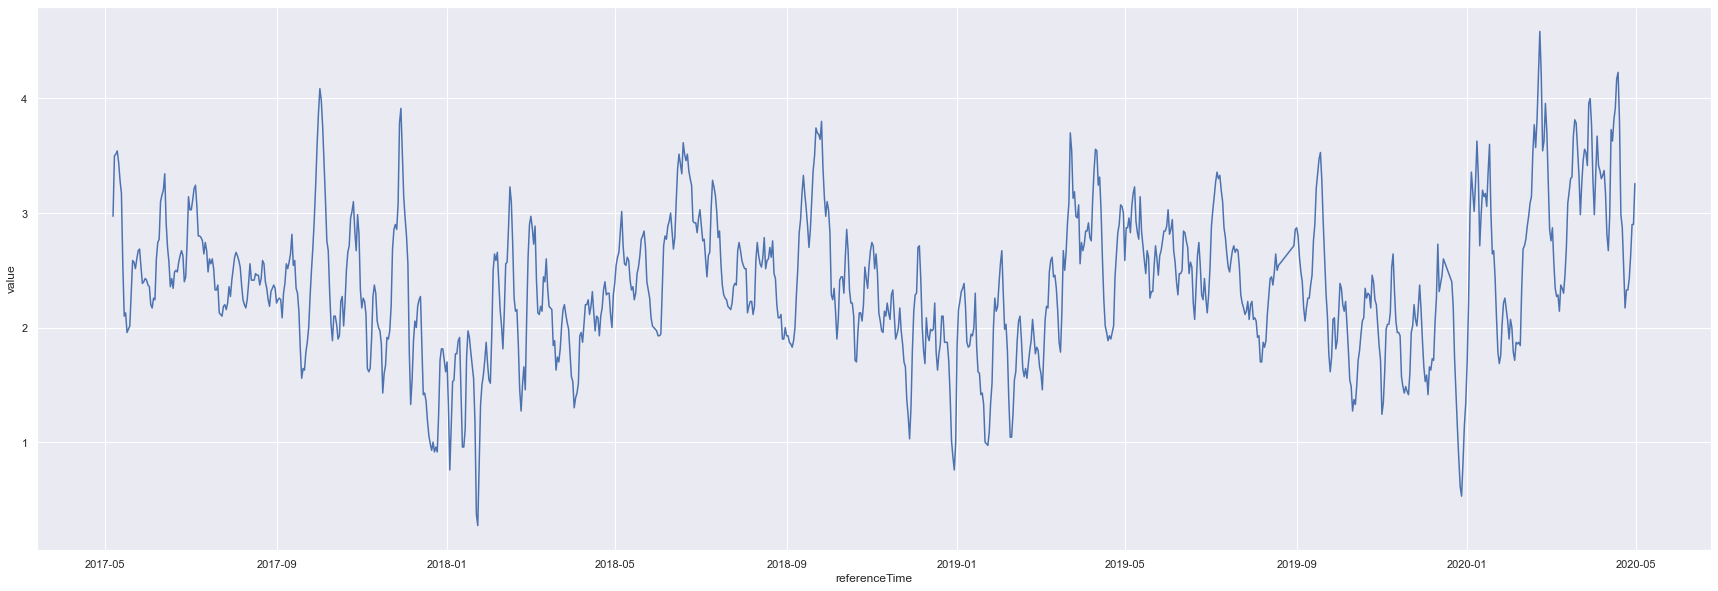

In [486]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

dfplot=df3.copy()
dfplot['value']=df3['value'].rolling(7).mean()

plt.figure(figsize=(30,10))
ax = sns.lineplot(x="referenceTime", y="value", data=dfplot)

In [106]:
ws = graphelement(source='SN4200', elements= 'wind_speed',referencetime= '2020-12-01/2021-01-01',rollingmean=1)
ws = ws.set_index("referenceTime").resample('10T').mean().value
wd = graphelement(source='SN4200', elements= 'wind_from_direction',referencetime= '2020-12-01/2021-01-01',rollingmean=1)
wd = wd.set_index("referenceTime").resample('10T').mean().value

Data retrieved from frost.met.no!
Data retrieved from frost.met.no!


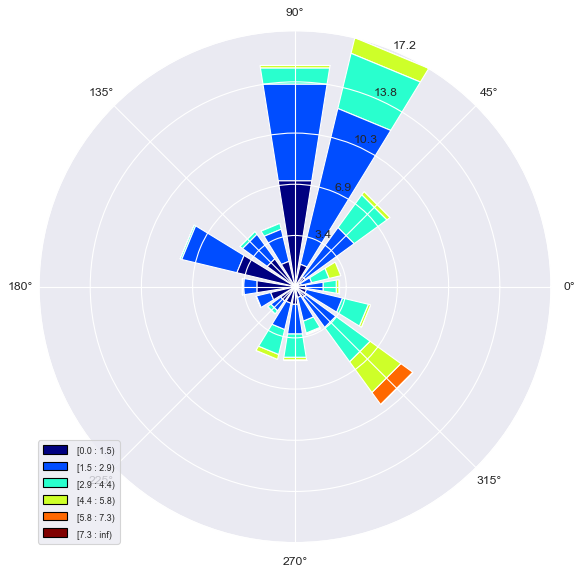

In [109]:
from windrose import WindroseAxes
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Create wind speed and direction variables

# ws = np.random.random(500) * 6
# wd = np.random.random(500) * 360

ax = WindroseAxes.from_ax()
ax.bar(wd, ws, normed=True, opening=0.8, edgecolor='white')
ax.set_legend()

In [126]:
from datetime import datetime, timedelta

today = datetime.today().strftime('%Y-%m-%d')
today3m = (datetime.today() - timedelta(days=90)).date()
trange = str(today3m)+'/'+str(today)
trange

'2020-11-13/2021-02-11'

In [9]:
dfoslo.columns

Index(['@type', 'id', 'name', 'shortName', 'country', 'countryCode', 'masl',
       'validFrom', 'county', 'countyId', 'municipality', 'municipalityId',
       'stationHolders', 'wigosId', 'geometry.@type', 'geometry.coordinates',
       'geometry.nearest', 'wmoId', 'externalIds'],
      dtype='object')

In [72]:
np.nan

nan

In [69]:
import plotly.graph_objects as go

mapbox_access_token = open(".mapbox_token").read()

dff = df.iloc[df['geometry.coordinates'].dropna().index]

fig = go.Figure(go.Scattermapbox(
        lat=[each[1] for each in dff['geometry.coordinates']],
        lon=[each[0] for each in dff['geometry.coordinates']],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=6
        ),
        text=[list(pair) for pair in zip(dff.name, dff.municipality)],
    ))

fig.update_layout(
    autosize=True,
    hovermode='closest',
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=dict(
            lat=65,
            lon=16
        ),
        pitch=0,
        zoom=2.5
    ),
)

fig.show()